# Network regularisation and preprocessing

In this tutorial we'll build directly on top of what we did in the amplitude regression task in the previous tutorial.  The first goal is to learn about the issue of over-training, and how to overcome it with network regularisation and early stopping. The second goal is to learn more about the different types of preprocessing that can be used in machine learning.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
     - limit the training data to just 1000 events, keeping 30k for validation and testing
     - this is unrealistic, but a good way to understand over-fitting and how to fix it
 - Visualising the data
 - Preprocessing the data
 - Datasets and dataloaders
     - choose a sensible batch size, say 64
 - Building the neural network
     - use a larger network, say 3 layers with hidden dimensions of 50
     - train for a long time, 1000-1500 epochs
 - Plot the train and validation losses as a function of the epochs
     - now you should clearly see the over-training problem
 - Network regularisation
     - Dropout
     - Early stopping

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

In [3]:
trn_dat = np.load( "tutorial-2-data/trn_dat.npy" )
trn_amp = np.load( "tutorial-2-data/trn_amp.npy" )

val_dat = np.load( "tutorial-2-data/val_dat.npy" )
val_amp = np.load( "tutorial-2-data/val_amp.npy" )

tst_dat = np.load( "tutorial-2-data/tst_dat.npy" )
tst_amp = np.load( "tutorial-2-data/tst_amp.npy" )

In [4]:
print( f"train data shape: {trn_dat.shape}" )
print( f"train amp  shape: {trn_amp.shape}" )
print( f"test  data shape: {tst_dat.shape}" )
print( f"test  amp  shape: {tst_amp.shape}" )
print( f"val   data shape: {val_dat.shape}" )
print( f"val   amp  shape: {val_amp.shape}" )

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


Let's say we have much less data:

In [5]:
trn_dat = trn_dat[0:1000]
trn_amp = trn_amp[0:1000]
print( f"train data shape: {trn_dat.shape}" )
print( f"train amp  shape: {trn_amp.shape}" )

train data shape: (1000, 5, 4)
train amp  shape: (1000,)


This is slightly unrealistic, but useful for demonstration purposes.  In practice we might use much larger networks than we use here, and so the number of parameters can be of the same order of magnitude as the number of training events.  This is when we encounter the problem of over-training.

## Visualising the data

Below we will make some kinematic plots of the events in the training sample.  Note however that these are not the physical distributions we would measure at the LHC!  In our training data each of these events is associated with an amplitude, which tells us the probability that the event will be produced in the gluon-gluon interaction.  So to get the physical distributions these events would need to be 'weighted' by their amplitude.  However, right now we just want to visualise our training dataset to see what preprocessing we should do.

In [6]:
def get_init_pz( ev ):
    return ev[0][3] + ev[1][3]

def get_mass( fv ):
    msq = np.round( fv[0]**2 - fv[1]**2 - fv[2]**2 - fv[3]**2 , 5 )
    if msq>0:
        return np.sqrt( msq )
    elif msq<0:
        raise Exception( "mass squared is less than zero" ) 
    else:
        return 0
    
def get_pt( fv ):
    ptsq = np.round( fv[1]**2 + fv[2]**2 , 5 )
    if ptsq>0:
        return np.sqrt( ptsq )
    elif ptsq<0:
        raise Exception( "$p_T$ squared is less than zero" ) 
    else:
        return 0
    
def get_met( ev ):
    return np.abs( np.sum( [ fv[1]+fv[2] for fv in ev ] ) )

We can plot a histogram of the amplitudes for the training data.

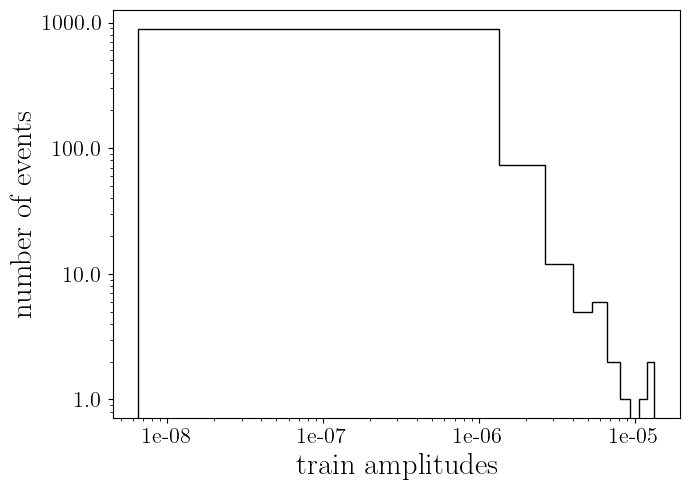

In [7]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_amp, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )
axs.set_xscale( 'log' )

axs.set_xlabel( "train amplitudes", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

The amplitudes span about 4 orders of magnitude...

Plotting the leading photon $p_T$.

In [8]:
trn_dat_leading_photon_pt = []
for ev in trn_dat:
    trn_dat_leading_photon_pt.append( get_pt( ev[2] ) )

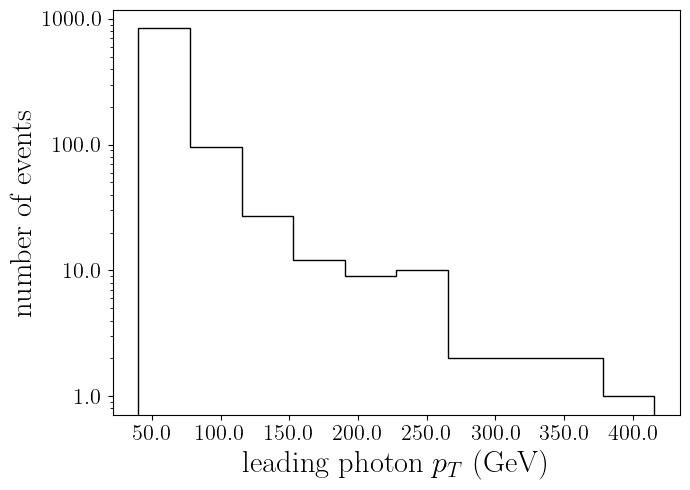

In [9]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_dat_leading_photon_pt, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )

axs.set_xlabel( "leading photon $p_T$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

Plot the final state gluon $p_T$.

In [10]:
trn_dat_gluon_pt = []
for ev in trn_dat:
    trn_dat_gluon_pt.append( get_pt( ev[4] ) )

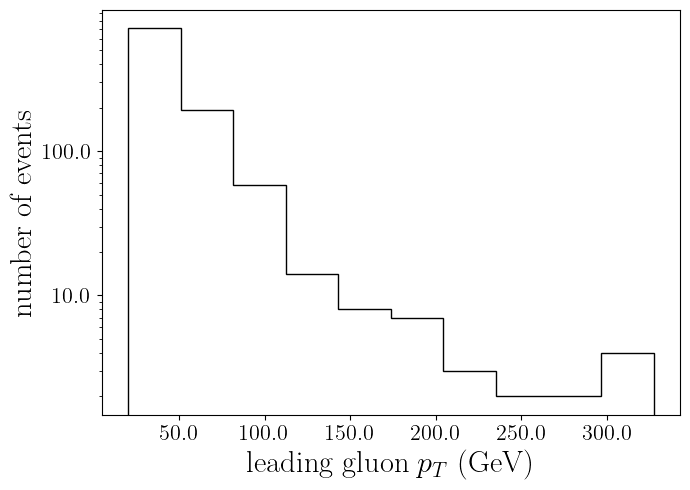

In [11]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_dat_gluon_pt, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )

axs.set_xlabel( "leading gluon $p_T$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

## Preprocessing the data

We will be using a dense network, so the data needs to be in vector format.  We will collapse the data for each event to a single vector of dimension $5\times4=20$.  The fact that the data is ordered here is important.  To predict the amplitude given the kinematics, the network needs to know which entries correspond to which particles in the process.

In [12]:
trn_nev = trn_dat.shape[0]
val_nev = val_dat.shape[0]
tst_nev = tst_dat.shape[0]
trn_datf = np.reshape( trn_dat, (trn_nev,-1) )
val_datf = np.reshape( val_dat, (val_nev,-1) )
tst_datf = np.reshape( tst_dat, (tst_nev,-1) )

Check the shape:

In [13]:
trn_datf.shape

(1000, 20)

There are further preprocessing steps we can take.  For example, the inputs are numerically very large $\mathcal{O}(100)$ and span a large range.  So we could re-scale the inputs by a constant number, or even take the logarithm of the inputs.

For now, we'll just re-scale by a constant number, the average final state gluon $p_T$, assuming that this is a natural scale for the problem.  And we should be careful to preprocess the train, validation, and test data in the exact same way.

In [14]:
trn_dat_gluon_pt = []
for ev in trn_dat:
    trn_dat_gluon_pt.append( get_pt( ev[4] ) )

In [15]:
gpt = np.mean( trn_dat_gluon_pt )
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

We should also preprocess the amplitude data.  As we seen in a plot above, the amplitudes span about 4 orders of magnitude.  This could be difficult for the network to interpolate.  We can aleviate the problem with preprocessing, taking the logarithm of the amplitudes.

In [16]:
trn_ampl = np.log( trn_amp )
val_ampl = np.log( val_amp )
tst_ampl = np.log( tst_amp )

The new distribution looks nicer:

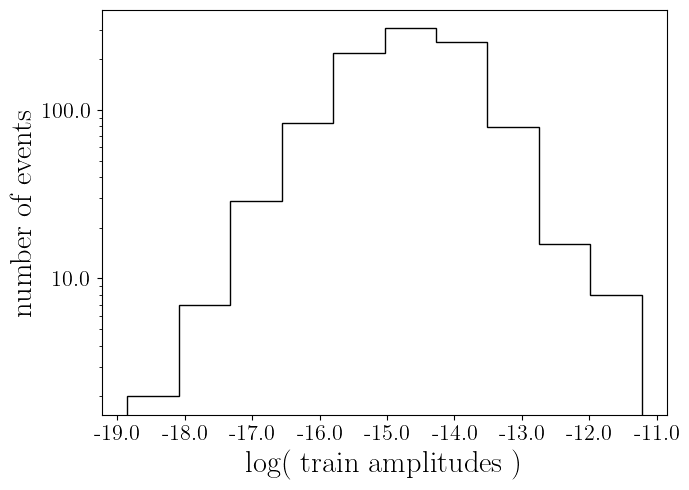

In [17]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_ampl, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )

axs.set_xlabel( "log( train amplitudes )", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

## Building the neural network

In [18]:
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
l_rate = 0.001
epochs = 1000

In [19]:
def make_model(ipt_dim, opt_dim, hdn_dim):
    input_la = keras.Input(shape=(ipt_dim,)) #input layer
    model = keras.Sequential([input_la])
    for _, acti_func in zip(range(3), [activations.relu,activations.relu,activations.relu]): #inclusion of all the other layers with respective act. function
        model.add(layers.Dense(hdn_dim, activation=acti_func))
    model.add(layers.Dense(opt_dim)) #output layer
    return model

In [20]:
model = make_model(ipt_dim, opt_dim, hdn_dim)
loss_mse = keras.losses.MeanSquaredError() #loss function
opt_SGD = keras.optimizers.Adam(learning_rate = l_rate ) #optimizer
model.compile(loss=loss_mse, optimizer = opt_SGD)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1050      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 6,201
Trainable params: 6,201
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist = model.fit(x = trn_datf, y = trn_ampl, batch_size = 64, epochs = epochs, validation_data = (val_datf,val_ampl))

Epoch 1/1000


2023-03-30 17:36:49.800578: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 13ms/step - loss: 172.4038 - val_loss: 121.1530
Epoch 2/1000
16/16 [==============================] - 0s 9ms/step - loss: 79.3903 - val_loss: 42.6925
Epoch 3/1000
16/16 [==============================] - 0s 9ms/step - loss: 40.2014 - val_loss: 41.5355
Epoch 4/1000
16/16 [==============================] - 0s 9ms/step - loss: 36.1334 - val_loss: 36.5140
Epoch 5/1000
16/16 [==============================] - 0s 8ms/step - loss: 33.8484 - val_loss: 34.6306
Epoch 6/1000
16/16 [==============================] - 0s 8ms/step - loss: 31.0803 - val_loss: 32.1584
Epoch 7/1000
16/16 [==============================] - 0s 8ms/step - loss: 28.7471 - val_loss: 29.7060
Epoch 8/1000
16/16 [==============================] - 0s 8ms/step - loss: 26.0883 - val_loss: 27.1165
Epoch 9/1000
16/16 [==============================] - 0s 8ms/step - loss: 23.3825 - val_loss: 24.1677
Epoch 10/1000
16/16 [==============================] - 0s 8ms/step - loss: 20.2575 - val_los

16/16 [==============================] - 0s 8ms/step - loss: 0.1616 - val_loss: 0.6522
Epoch 83/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.1578 - val_loss: 0.5477
Epoch 84/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1509 - val_loss: 0.5952
Epoch 85/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1658 - val_loss: 0.6161
Epoch 86/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1532 - val_loss: 0.5519
Epoch 87/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1518 - val_loss: 0.5564
Epoch 88/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1452 - val_loss: 0.5877
Epoch 89/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1503 - val_loss: 0.5336
Epoch 90/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1440 - val_loss: 0.5586
Epoch 91/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1424 - val_loss: 0.5351
Epoc

16/16 [==============================] - 0s 8ms/step - loss: 0.0877 - val_loss: 0.4080
Epoch 163/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0962 - val_loss: 0.4070
Epoch 164/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0881 - val_loss: 0.4289
Epoch 165/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0877 - val_loss: 0.4339
Epoch 166/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0814 - val_loss: 0.4040
Epoch 167/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0820 - val_loss: 0.4155
Epoch 168/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0823 - val_loss: 0.4082
Epoch 169/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0887 - val_loss: 0.4147
Epoch 170/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0876 - val_loss: 0.4197
Epoch 171/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0783 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.0673 - val_loss: 0.3384
Epoch 243/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0525 - val_loss: 0.3443
Epoch 244/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0662 - val_loss: 0.3698
Epoch 245/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0603 - val_loss: 0.3641
Epoch 246/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0529 - val_loss: 0.3533
Epoch 247/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0485 - val_loss: 0.3335
Epoch 248/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0514 - val_loss: 0.3421
Epoch 249/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0708 - val_loss: 0.3378
Epoch 250/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0734 - val_loss: 0.3445
Epoch 251/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0641 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.0358 - val_loss: 0.2972
Epoch 323/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0384 - val_loss: 0.2979
Epoch 324/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0362 - val_loss: 0.2989
Epoch 325/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0390 - val_loss: 0.2966
Epoch 326/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0351 - val_loss: 0.3152
Epoch 327/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0416 - val_loss: 0.3165
Epoch 328/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0469 - val_loss: 0.3270
Epoch 329/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0448 - val_loss: 0.2985
Epoch 330/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0419 - val_loss: 0.2984
Epoch 331/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.0311 - val_loss: 0.2669
Epoch 403/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0294 - val_loss: 0.2908
Epoch 404/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0327 - val_loss: 0.2725
Epoch 405/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0323 - val_loss: 0.3637
Epoch 406/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0361 - val_loss: 0.2857
Epoch 407/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0391 - val_loss: 0.2805
Epoch 408/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0433 - val_loss: 0.2774
Epoch 409/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0529 - val_loss: 0.3214
Epoch 410/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0385 - val_loss: 0.2820
Epoch 411/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0276 - val_loss: 0

16/16 [==============================] - 0s 8ms/step - loss: 0.0240 - val_loss: 0.2655
Epoch 483/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0222 - val_loss: 0.2838
Epoch 484/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0248 - val_loss: 0.2592
Epoch 485/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0253 - val_loss: 0.2846
Epoch 486/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0230 - val_loss: 0.2600
Epoch 487/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.2576
Epoch 488/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0300 - val_loss: 0.2721
Epoch 489/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0313 - val_loss: 0.3029
Epoch 490/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0482 - val_loss: 0.2776
Epoch 491/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0290 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.0361 - val_loss: 0.2761
Epoch 563/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.2609
Epoch 564/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0187 - val_loss: 0.2660
Epoch 565/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.2865
Epoch 566/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0320 - val_loss: 0.2979
Epoch 567/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0516 - val_loss: 0.3065
Epoch 568/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0349 - val_loss: 0.2656
Epoch 569/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0255 - val_loss: 0.3017
Epoch 570/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0358 - val_loss: 0.2853
Epoch 571/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0320 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.2684
Epoch 643/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0158 - val_loss: 0.2621
Epoch 644/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0208 - val_loss: 0.2735
Epoch 645/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0180 - val_loss: 0.2563
Epoch 646/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0209 - val_loss: 0.2743
Epoch 647/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0166 - val_loss: 0.2889
Epoch 648/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0184 - val_loss: 0.2731
Epoch 649/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0171 - val_loss: 0.2694
Epoch 650/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0150 - val_loss: 0.2691
Epoch 651/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0152 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.2603
Epoch 723/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.2645
Epoch 724/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.2601
Epoch 725/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0173 - val_loss: 0.2470
Epoch 726/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0136 - val_loss: 0.2623
Epoch 727/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.2510
Epoch 728/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 0.2595
Epoch 729/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.2592
Epoch 730/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0129 - val_loss: 0.2483
Epoch 731/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0172 - val_loss:

16/16 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.2505
Epoch 803/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0118 - val_loss: 0.2461
Epoch 804/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.2405
Epoch 805/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0113 - val_loss: 0.2539
Epoch 806/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0117 - val_loss: 0.2428
Epoch 807/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.2499
Epoch 808/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0120 - val_loss: 0.2424
Epoch 809/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0154 - val_loss: 0.2512
Epoch 810/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0126 - val_loss: 0.2478
Epoch 811/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0235 - val_loss: 0.

16/16 [==============================] - 0s 9ms/step - loss: 0.0178 - val_loss: 0.2376
Epoch 883/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0133 - val_loss: 0.2427
Epoch 884/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0107 - val_loss: 0.2337
Epoch 885/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0178 - val_loss: 0.2571
Epoch 886/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0164 - val_loss: 0.2635
Epoch 887/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0203 - val_loss: 0.2425
Epoch 888/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0164 - val_loss: 0.2611
Epoch 889/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0283 - val_loss: 0.2432
Epoch 890/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0175 - val_loss: 0.2343
Epoch 891/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0123 - val_los

16/16 [==============================] - 0s 8ms/step - loss: 0.0189 - val_loss: 0.2315
Epoch 963/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.2496
Epoch 964/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.2309
Epoch 965/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.2350
Epoch 966/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 0.2308
Epoch 967/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0194 - val_loss: 0.2563
Epoch 968/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0224 - val_loss: 0.2367
Epoch 969/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0117 - val_loss: 0.2382
Epoch 970/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0116 - val_loss: 0.2385
Epoch 971/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0

## Plot the train and validation losses as a function of the epochs

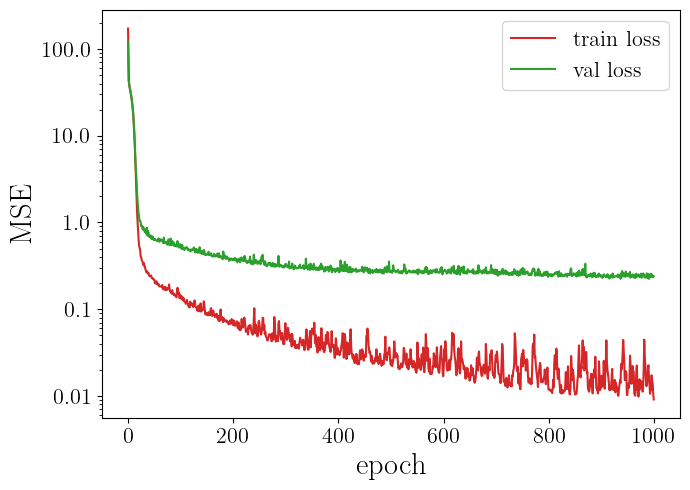

In [22]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'
trn_losses = hist.history['loss']
val_losses = hist.history['val_loss']
axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

This is a good example of a network over-training.  At some point, the loss evaluated on the training data continues to improve, while the loss on the validation data converges to a lower limit.  In practice, it often happens that the validation loss actually gets worse when the network over-trains, so the problem can be worse than shown here.

## Network regularisation

### Dropout

Dropout is a mechanism to reduce over-fitting effects in neural network optimisation.  It was proposed in this paper (I think):

------------------

**Improving neural networks by preventing co-adaptation of feature detectors**

https://arxiv.org/abs/1207.0580

When a large feedforward neural network is trained on a small training set, it typically performs poorly on held-out test data. This "overfitting" is greatly reduced by randomly omitting half of the feature detectors on each training case. This prevents complex co-adaptations in which a feature detector is only helpful in the context of several other specific feature detectors. Instead, each neuron learns to detect a feature that is generally helpful for producing the correct answer given the combinatorially large variety of internal contexts in which it must operate. Random "dropout" gives big improvements on many benchmark tasks and sets new records for speech and object recognition. 

------------------

So let's build the same model, but with dropout:

In [23]:
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
l_rate = 0.001
epochs = 1000
rate = 0.5

In [24]:
def make_model(ipt_dim, opt_dim, hdn_dim):
    input_la = keras.Input(shape=(ipt_dim,)) #input layer
    model = keras.Sequential([input_la])
    for _, acti_func in zip(range(3), [activations.relu,activations.relu,activations.relu]): #inclusion of all the other layers with respective act. function
        model.add(layers.Dropout(rate))
        model.add(layers.Dense(hdn_dim, activation=acti_func))
    model.add(layers.Dense(opt_dim)) #output layer
    return model

In [25]:
model = make_model(ipt_dim, opt_dim, hdn_dim)
loss_mse = keras.losses.MeanSquaredError() #loss function
opt_SGD = keras.optimizers.Adam(learning_rate = l_rate ) #optimizer
model.compile(loss=loss_mse, optimizer = opt_SGD)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                1050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [26]:
hist = model.fit(x = trn_datf, y = trn_ampl, batch_size = 64, epochs = epochs, validation_data = (val_datf,val_ampl))

Epoch 1/1000
16/16 [==============================] - 0s 12ms/step - loss: 177.8360 - val_loss: 134.6490
Epoch 2/1000
16/16 [==============================] - 0s 9ms/step - loss: 94.3128 - val_loss: 62.8149
Epoch 3/1000
16/16 [==============================] - 0s 8ms/step - loss: 78.1940 - val_loss: 58.3787
Epoch 4/1000
16/16 [==============================] - 0s 8ms/step - loss: 74.1478 - val_loss: 68.9551
Epoch 5/1000
16/16 [==============================] - 0s 8ms/step - loss: 61.2194 - val_loss: 60.0823
Epoch 6/1000
16/16 [==============================] - 0s 8ms/step - loss: 69.4984 - val_loss: 60.5944
Epoch 7/1000
16/16 [==============================] - 0s 8ms/step - loss: 58.9814 - val_loss: 58.6605
Epoch 8/1000
16/16 [==============================] - 0s 8ms/step - loss: 52.0831 - val_loss: 57.9987
Epoch 9/1000
16/16 [==============================] - 0s 8ms/step - loss: 52.3915 - val_loss: 57.8624
Epoch 10/1000
16/16 [==============================] - 0s 8ms/step - loss: 51.1

16/16 [==============================] - 0s 8ms/step - loss: 3.7392 - val_loss: 1.9218
Epoch 82/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.7721 - val_loss: 1.9967
Epoch 83/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.6973 - val_loss: 2.0222
Epoch 84/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.7540 - val_loss: 2.0354
Epoch 85/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.3613 - val_loss: 1.9383
Epoch 86/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.4975 - val_loss: 1.8104
Epoch 87/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.3716 - val_loss: 2.0618
Epoch 88/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.0452 - val_loss: 1.4773
Epoch 89/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.1531 - val_loss: 1.9326
Epoch 90/1000
16/16 [==============================] - 0s 8ms/step - loss: 3.0913 - val_loss: 1.8128
Epoc

16/16 [==============================] - 0s 8ms/step - loss: 1.0481 - val_loss: 1.1307
Epoch 162/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.0311 - val_loss: 1.1649
Epoch 163/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9983 - val_loss: 1.0686
Epoch 164/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.0744 - val_loss: 1.0516
Epoch 165/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.0077 - val_loss: 1.0751
Epoch 166/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9624 - val_loss: 1.1257
Epoch 167/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.0129 - val_loss: 1.1390
Epoch 168/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9881 - val_loss: 1.0729
Epoch 169/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.0476 - val_loss: 1.0582
Epoch 170/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.0189 - val_loss: 1.

16/16 [==============================] - 0s 8ms/step - loss: 0.9627 - val_loss: 1.0157
Epoch 242/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9091 - val_loss: 0.9990
Epoch 243/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9432 - val_loss: 1.0575
Epoch 244/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9294 - val_loss: 1.0508
Epoch 245/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9651 - val_loss: 1.0320
Epoch 246/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9282 - val_loss: 1.0651
Epoch 247/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9168 - val_loss: 1.1114
Epoch 248/1000
16/16 [==============================] - 0s 8ms/step - loss: 1.0005 - val_loss: 1.1086
Epoch 249/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9345 - val_loss: 1.0513
Epoch 250/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9654 - val_loss: 1.

16/16 [==============================] - 0s 8ms/step - loss: 0.9113 - val_loss: 1.1475
Epoch 322/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9829 - val_loss: 1.0252
Epoch 323/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9205 - val_loss: 0.9927
Epoch 324/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9363 - val_loss: 1.0723
Epoch 325/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9203 - val_loss: 1.0154
Epoch 326/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9699 - val_loss: 1.1002
Epoch 327/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9354 - val_loss: 1.1033
Epoch 328/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9129 - val_loss: 1.0170
Epoch 329/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9022 - val_loss: 1.0255
Epoch 330/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8898 - val_loss: 1.

16/16 [==============================] - 0s 8ms/step - loss: 0.9182 - val_loss: 0.9555
Epoch 402/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8881 - val_loss: 1.0243
Epoch 403/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8915 - val_loss: 0.9416
Epoch 404/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8974 - val_loss: 0.9723
Epoch 405/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9353 - val_loss: 0.9066
Epoch 406/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9259 - val_loss: 1.0119
Epoch 407/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9200 - val_loss: 0.9439
Epoch 408/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8870 - val_loss: 0.9318
Epoch 409/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9169 - val_loss: 0.9675
Epoch 410/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.9558 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.8287 - val_loss: 0.9411
Epoch 482/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8740 - val_loss: 0.8521
Epoch 483/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8401 - val_loss: 0.9344
Epoch 484/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8373 - val_loss: 0.9382
Epoch 485/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8178 - val_loss: 1.0774
Epoch 486/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8342 - val_loss: 1.0258
Epoch 487/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7920 - val_loss: 0.8727
Epoch 488/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8393 - val_loss: 0.9383
Epoch 489/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8862 - val_loss: 0.9353
Epoch 490/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8096 - val_loss: 1.

16/16 [==============================] - 0s 8ms/step - loss: 0.7723 - val_loss: 0.9424
Epoch 562/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7765 - val_loss: 0.7889
Epoch 563/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8461 - val_loss: 0.7975
Epoch 564/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8061 - val_loss: 0.8300
Epoch 565/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7815 - val_loss: 0.8301
Epoch 566/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8285 - val_loss: 0.8452
Epoch 567/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7776 - val_loss: 0.8009
Epoch 568/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8370 - val_loss: 0.8409
Epoch 569/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8345 - val_loss: 0.8451
Epoch 570/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8682 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.7264 - val_loss: 0.9373
Epoch 642/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7448 - val_loss: 0.8466
Epoch 643/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7717 - val_loss: 0.8425
Epoch 644/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8044 - val_loss: 0.9279
Epoch 645/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7901 - val_loss: 0.8548
Epoch 646/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8305 - val_loss: 0.9736
Epoch 647/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.7788 - val_loss: 0.9609
Epoch 648/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8231 - val_loss: 0.9615
Epoch 649/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.8072 - val_loss: 0.9616
Epoch 650/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7625 - val_loss: 1.

16/16 [==============================] - 0s 8ms/step - loss: 0.7705 - val_loss: 0.8927
Epoch 722/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7589 - val_loss: 0.9029
Epoch 723/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7407 - val_loss: 0.8741
Epoch 724/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7517 - val_loss: 0.8359
Epoch 725/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7902 - val_loss: 0.8732
Epoch 726/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7013 - val_loss: 0.7895
Epoch 727/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7523 - val_loss: 0.7719
Epoch 728/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7887 - val_loss: 0.8514
Epoch 729/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7963 - val_loss: 0.8560
Epoch 730/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7384 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.6984 - val_loss: 0.7988
Epoch 802/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7396 - val_loss: 0.8305
Epoch 803/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7830 - val_loss: 0.8322
Epoch 804/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7311 - val_loss: 0.8597
Epoch 805/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7272 - val_loss: 0.8345
Epoch 806/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7642 - val_loss: 0.8020
Epoch 807/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7228 - val_loss: 0.8543
Epoch 808/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7341 - val_loss: 0.8259
Epoch 809/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7122 - val_loss: 0.8167
Epoch 810/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7250 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.6914 - val_loss: 0.8125
Epoch 882/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6952 - val_loss: 0.7588
Epoch 883/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6908 - val_loss: 0.8451
Epoch 884/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7112 - val_loss: 0.8090
Epoch 885/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6925 - val_loss: 0.8873
Epoch 886/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7603 - val_loss: 0.9430
Epoch 887/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7283 - val_loss: 0.8400
Epoch 888/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7109 - val_loss: 0.7890
Epoch 889/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7026 - val_loss: 0.8664
Epoch 890/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7211 - val_loss: 0.

16/16 [==============================] - 0s 8ms/step - loss: 0.6388 - val_loss: 0.8046
Epoch 962/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7120 - val_loss: 0.7493
Epoch 963/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6841 - val_loss: 0.8330
Epoch 964/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6897 - val_loss: 0.8486
Epoch 965/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6926 - val_loss: 0.7975
Epoch 966/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7066 - val_loss: 0.8173
Epoch 967/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6675 - val_loss: 0.7981
Epoch 968/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.7259 - val_loss: 0.8271
Epoch 969/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6724 - val_loss: 0.8414
Epoch 970/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6554 - val_loss: 0.

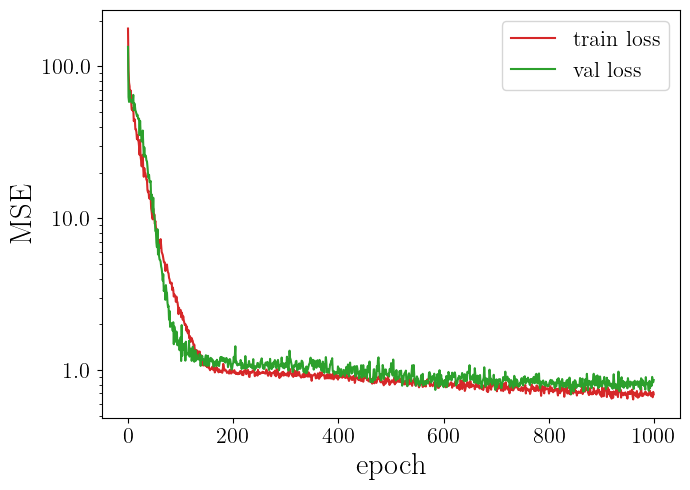

In [27]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

trn_losses_dr = hist.history['loss']
val_losses_dr = hist.history['val_loss']
axs.plot( trn_losses_dr, label="train loss", color=c1 )
axs.plot( val_losses_dr, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

Clearly, we can see that dropout has completely prevented over-training!

### Early stopping

As we saw in one of the previous plots in a training without any regularization the validation loss typically stops decreasing after a while (or in the worst case even starts increasing) while the training loss keeps on decreasining. The idea of Early Stopping is to simply stop the training when this happens.

------------
Copy paste again..

The trigger condition can be arbitrarily complicated but in its simpliest version we just compare the current value of the validation loss with the previous value. However, because the validation dataset is typically small and the validation loss therefore prone to statistical fluctuations, we should not immediately stop the training the first time the breaking condition is triggered. Instead, we introduce the new hyperparameter 'patience' which tells us how many epochs we want to wait before stopping the training.

In [33]:
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
l_rate = 0.001
epochs = 1000
patience = 4

In [34]:
def make_model(ipt_dim, opt_dim, hdn_dim):
    input_la = keras.Input(shape=(ipt_dim,)) #input layer
    model = keras.Sequential([input_la])
    for _, acti_func in zip(range(3), [activations.relu,activations.relu,activations.relu]): #inclusion of all the other layers with respective act. function
        model.add(layers.Dense(hdn_dim, activation=acti_func))
    model.add(layers.Dense(opt_dim)) #output layer
    return model

In [35]:
model = make_model(ipt_dim, opt_dim, hdn_dim)
loss_mse = keras.losses.MeanSquaredError() #loss function
opt_SGD = keras.optimizers.Adam(learning_rate = l_rate ) #optimizer
callback = tf.keras.callbacks.EarlyStopping(patience=patience) # early_stopping
model.compile(loss=loss_mse, optimizer = opt_SGD)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 50)                1050      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 6,201
Trainable params: 6,201
Non-trainable params: 0
_________________________________________________________________


In [36]:
hist = model.fit(x = trn_datf, y = trn_ampl, batch_size = 64, callbacks=[callback], epochs = epochs, validation_data = (val_datf,val_ampl))

Epoch 1/1000
16/16 [==============================] - 1s 12ms/step - loss: 191.1286 - val_loss: 138.7669
Epoch 2/1000
16/16 [==============================] - 0s 8ms/step - loss: 96.1553 - val_loss: 49.3558
Epoch 3/1000
16/16 [==============================] - 0s 8ms/step - loss: 41.9759 - val_loss: 45.5958
Epoch 4/1000
16/16 [==============================] - 0s 8ms/step - loss: 35.5723 - val_loss: 36.7614
Epoch 5/1000
16/16 [==============================] - 0s 8ms/step - loss: 33.6645 - val_loss: 34.7916
Epoch 6/1000
16/16 [==============================] - 0s 8ms/step - loss: 31.4444 - val_loss: 33.3167
Epoch 7/1000
16/16 [==============================] - 0s 8ms/step - loss: 29.8354 - val_loss: 31.4990
Epoch 8/1000
16/16 [==============================] - 0s 8ms/step - loss: 28.2972 - val_loss: 29.4145
Epoch 9/1000
16/16 [==============================] - 0s 8ms/step - loss: 26.4756 - val_loss: 27.5574
Epoch 10/1000
16/16 [==============================] - 0s 8ms/step - loss: 24.7

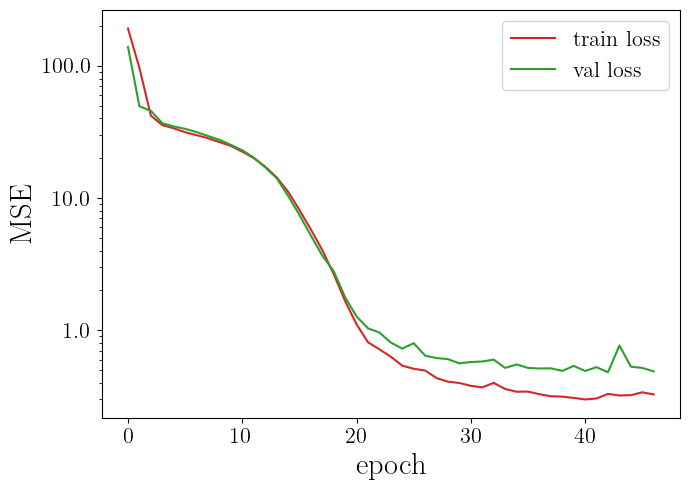

In [37]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

trn_losses_es = hist.history['loss']
val_losses_es = hist.history['val_loss']
axs.plot( trn_losses_es, label="train loss", color=c1 )
axs.plot( val_losses_es, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "MSE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

We can see here that the network has stopped training before the training loss diverges too far from the validation loss.